In [ ]:
%env LD_LIBRARY_PATH=/home/aiops/yueyang/.mujoco/mujoco210/bin

import numpy as np
import os

In [ ]:
def load_advs(path):
    res = np.load(path, allow_pickle=True).item()
    itr = max(res.keys())
    return res[itr]['adv'].squeeze()

def load_weights(path):
    adv = load_advs(path)
    w = adv - adv.min()
    w = w / w.sum() * w.shape[0]
    return w

def linear_weights(adv):
    w = adv - adv.min()
    w = w / w.sum() * w.shape[0]
    return w

def scale(w, s):
    return np.maximum((w - w.mean())  * s + w.mean(), 0)



In [ ]:
import matplotlib.pyplot as plt
import gym


def vis(dist, bins):
  plt.hist(dist, bins=bins)
  plt.show()

# vis(d4rl.qlearning_dataset('hopper-medium-replay-v2'))


In [ ]:
rp = 'weights/hopper-medium-replay-v2_returns.npy'
wp = [
    'weights/doublev_nstep_nstep_1_0.95_cosine_hopper-medium-replay-v2_1.npy',
    'weights/doublev_nstep_gae_1_0.95_cosine_hopper-medium-replay-v2_1.npy',
    # 'weights/doublev_nstep_nstep_1_0.95_cosine_hopper-medium-replay-v2_2.npy',
    # 'weights/doublev_nstep_gae_1_0.95_cosine_hopper-medium-replay-v2_1.npy',
    # 'weights/doublev_nstep_gae_1_0.95_cosine_hopper-medium-replay-v2_2.npy',
    'weights/doublev_nstep_nstep_3_0.95_cosine_hopper-medium-replay-v2_1.npy',
    # 'weights/doublev_nstep_nstep_3_0.95_cosine_hopper-medium-replay-v2_3.npy',
    'weights/doublev_nstep_gae_3_0.95_cosine_hopper-medium-replay-v2_1.npy',
    # 'weights/doublev_nstep_gae_3_0.95_cosine_hopper-medium-replay-v2_2.npy',
    # 'weights/doublev_nstep_nstep_10_0.95_cosine_hopper-medium-replay-v2_1.npy',
    'weights/doublev_nstep_nstep_10_0.95_cosine_hopper-medium-replay-v2_3.npy',
]

returns = np.load(rp)
rw = linear_weights(returns)
vis(rw, 50)
print(rw.mean(), rw.std())

for p in wp:
    print(p)
    adv = load_advs(p)
    w = linear_weights(adv)
    vis(w, 50)
    print(w.mean(), w.std())

    w = scale(w, 10)
    vis(w, 50)
    print(w.mean(), w.std())
    # print(p,'\n', adv[:20].squeeze().round(2))
print(adv.shape[0])


In [ ]:
# check seeds and methods
rp = 'weights/hopper-medium-replay-v2_returns.npy'
wp = 'weights/400000_6_200000_scale=False_halfcheetah-medium-expert-v2_1.npy'

returns = np.load(rp)
rw = linear_weights(returns)
print(rw.mean(), rw.std())
vis(rw, 50)

eval_res = np.load(wp, allow_pickle=True).item()
num_iter, bc_eval_steps = eval_res['iter'], eval_res['eval_steps']

for iter in range(1,7):
    # step = iter*bc_eval_steps
    w = eval_res[iter]
    # w = linear_weights(adv)
    print(iter, w.max(), w.std())
    vis(w, 50)

    # w = scale(w, 10)
    # vis(w, 50)
    # print(w.mean(), w.std())
    # print(p,'\n', adv[:20].squeeze().round(2))
print(w.shape[0])



In [ ]:
# check seeds and methods
rp = 'weights/hopper-medium-replay-v2_returns.npy'
wp = 'weights/doublev_nstep_nstep_1_0.95_cosine_5_400000_hopper-medium-replay-v2_1.npy'

returns = np.load(rp)
rw = linear_weights(returns)
vis(rw, 50)
print(rw.mean(), rw.std())

eval_res = np.load(wp, allow_pickle=True).item()
num_iter, bc_eval_steps = eval_res['iter'], eval_res['eval_steps']

for iter in range(1,6):
    step = iter*bc_eval_steps
    adv = eval_res[step]['adv']
    w = linear_weights(adv)
    print(step, w.max(), w.std())
    vis(w, 50)

    # w = scale(w, 10)
    # vis(w, 50)
    # print(w.mean(), w.std())
    # print(p,'\n', adv[:20].squeeze().round(2))
print(adv.shape[0])



3.4268150170173612 0.8034304826878058


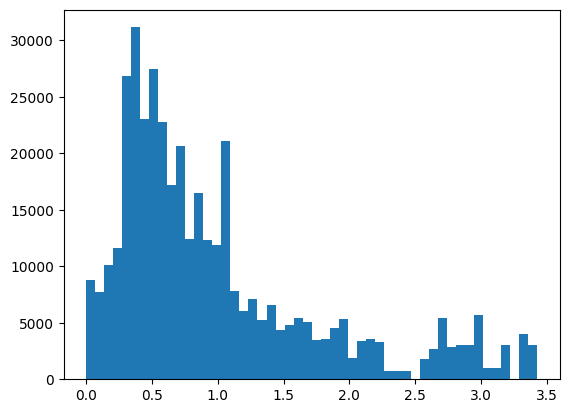

weights/400000_20_50000_scale=False_hopper-medium-replay-v2_3.npy
6.664821055496518 0.19093230232753106


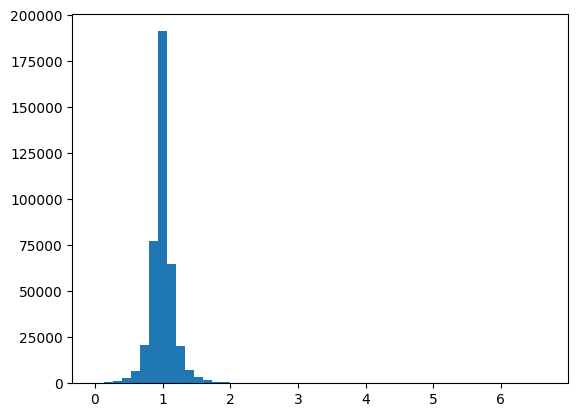

2.7316007806311973 0.7824851857866889


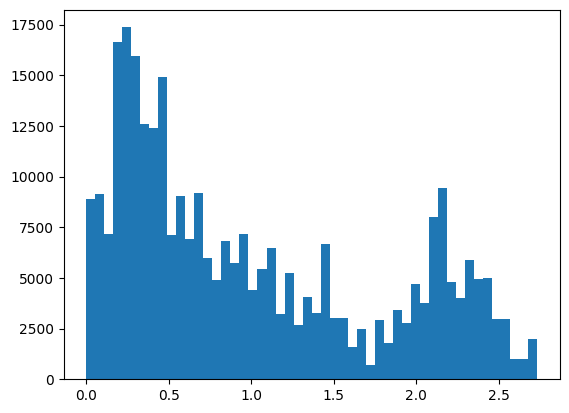

weights/400000_20_50000_scale=False_walker2d-medium-replay-v2_3.npy
15.953500083068354 0.4133502988523496


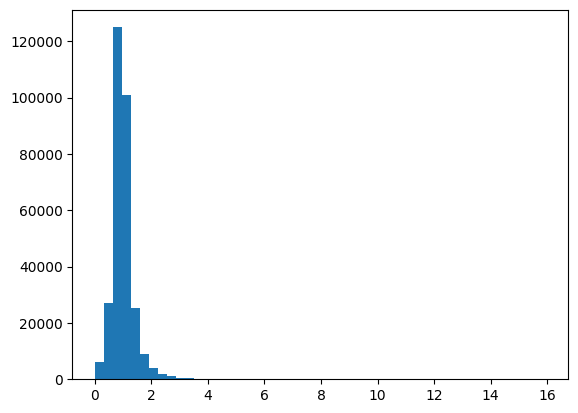

1.4409233491505802 0.3701735913368142


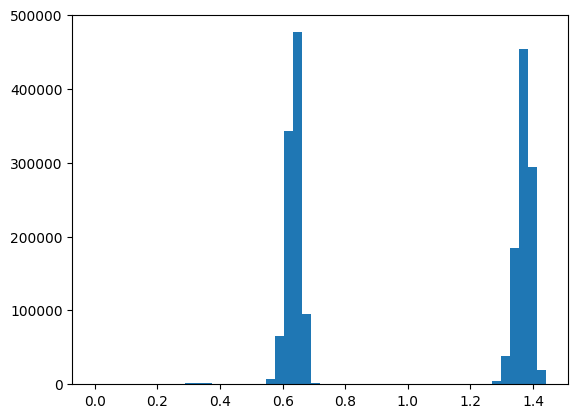

weights/400000_20_50000_scale=False_halfcheetah-medium-expert-v2_3.npy
38.77383609324387 0.2511794621774142


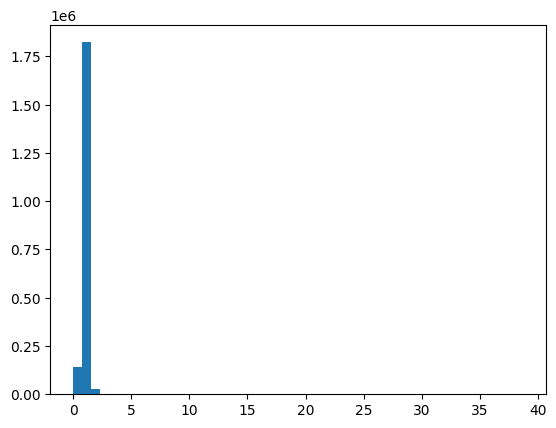

1.5555160083866895 0.4805471910882862


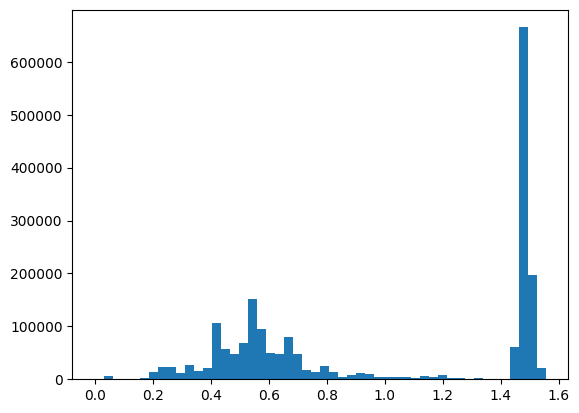

weights/400000_20_50000_scale=False_hopper-medium-expert-v2_3.npy
5.284510981209025 0.06070453009347458


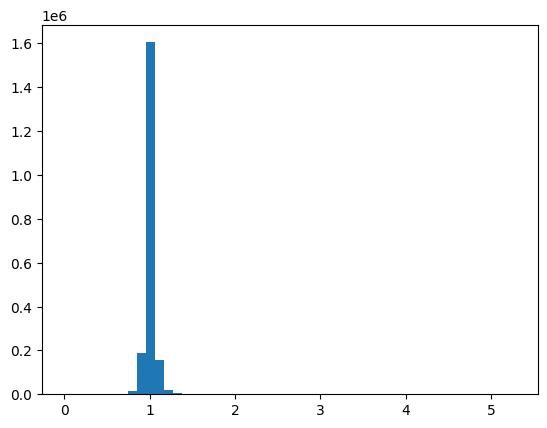

In [5]:
envs = ["hopper-medium-replay-v2", "walker2d-medium-replay-v2",
	"halfcheetah-medium-expert-v2", "hopper-medium-expert-v2"]

for env in envs:
    rp = f'weights/{env}_returns.npy'
    p = f'weights/400000_20_50000_scale=False_{env}_3.npy'

    returns = np.load(rp)
    rw = linear_weights(returns)
    print(rw.max(), rw.std())
    vis(rw, 50)

    eval_res = np.load(p, allow_pickle=True).item()
    w = eval_res[10]
    print(p)
    print(w.max(), w.std())
    vis(w, 50)
    

    # w = scale(w, 10)
    # vis(w, 50)
    # print(w.mean(), w.std())
    # # print(p,'\n', adv[:20].squeeze().round(2))
    # print(adv.shape[0])



In [ ]:
prefix = 'doublev_onestep_cosine'
for env in ['walker2d', 'hopper', 'halfcheetah']:
    for level in ['medium', 'medium-replay', 'medium-expert']:
        task = f'{env}-{level}-v2'
        print(task)
        for seed in range(6):
            path = f"./weights/{prefix}_{task}_{seed}.npy"
            weights = []
            if os.path.exists(path):
                weights.append(load_weights(path))
                print(f'seed {seed}', weights[-1].max().round(2), ' ', weights[-1][:10].round(2))
                idx = int(np.argmax(weights[-1], axis=0))
                print(weights[-1][idx-10:idx+10].round(2))
            else:
                print(f'{path} doesn\'t exists')
            
